# K-means

## Dataset

Crearemos un archivo para leer la dataset que se ubica en los archivos clase.txt y dataset_tissue.txt. Juntaremos la respectiva muestra con su clase para generar una única dataset. Para eso seguiremos los siguientes pasos.

In [51]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [52]:
names = pd.read_csv("./clase.txt")
dataset = pd.read_csv("./dataset_tissue.txt", skiprows=1, header=None).drop(0, axis=1).transpose()

In [53]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dataset)

pca = PCA(n_components=100)
principal_components = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(100)])

In [54]:
#Devuelve la distancia entre 2 vectores.
#Pruebe con varias funciones de distancia.
def distance(v1,v2): #v1 y v2 son np.array
  return np.linalg.norm(v1-v2)

In [55]:
# Inicialice los k centroides tomando aleatoriamente k elementos de los datos para que cada
# centroide tenga una ubicación inicial en el espacio de características.
# Nota, puede mejorar este algoritmo, inicializando los centroides de manera más inteligente.
def Init_Centroide(data,k):
  centroids = data[np.random.choice(range(len(data)), k, replace=False)]
  return centroids

In [56]:
# Dado que los grupos se han formado previamente, se pueden obtener nuevos
# centroides calculando el vector promedio de cada grupo.
def return_new_centroide(clusters, data,k):
  new_centroides = [np.mean(data[clusters == i], axis=0) for i in range(k) if data[clusters == i].size > 0]
  return new_centroides

In [57]:
# La función devuelve un vector de números entre 0 y k-1, donde cada valor indica la clase
# a la que pertenece cada elemento del dataset.
def get_cluster(data,centroides):
    clusters = [np.argmin([distance(punto, centroide) for centroide in centroides]) for punto in data]
    return np.array(clusters)

In [58]:
# Halla la distancia promedio entre los antiguos centroides y los nuevos centroides para evaluar
# la convergencia del algoritmo K-Means y determinar si se debe continuar con la iteración.
def distancia_promedio_centroides(old_centroide, new_centroide):
    distances = [distance(old, new) for old, new in zip(old_centroide, new_centroide)]
    return np.mean(distances)

## Algoritmo K-means

In [59]:
def kmeans(data, k, umbral):
  centroides =  Init_Centroide(data,k)
  clusters   =  get_cluster(data,centroides)
  new_centroides = return_new_centroide(clusters, data,k)
  while(distancia_promedio_centroides(centroides, new_centroides) > umbral):
     centroides = new_centroides
     clusters   =  get_cluster(data,centroides)
     new_centroides = return_new_centroide(clusters, data,k)

  return new_centroides, clusters

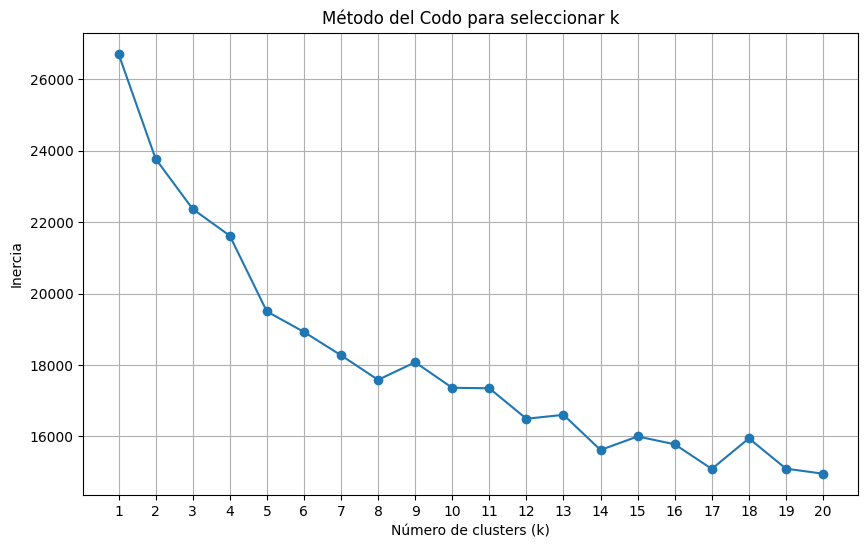

In [60]:
inertias = []
ks = range(1, 21)
umbral = 0.0001

for k in ks:
    new_centroides, clusters = kmeans(df_pca.to_numpy(), k, umbral)
    inertia = np.sum([distance(punto, new_centroides[cluster]) for punto, cluster in zip(df_pca.to_numpy(), clusters)])
    inertias.append(inertia)

# Graficar el método del codo
plt.figure(figsize=(10, 6))
plt.plot(ks, inertias, marker='o')
plt.title('Método del Codo para seleccionar k')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.xticks(ks)
plt.grid(True)
plt.show()

Escogemos el k=6 porque si observamos la gráfica después del 6 hay una estabilización de los datos. Sin embargo cuando se vuelve a ejecutar el codigo y calcular los PCA cambia el k, por lo que se puede decir que el k es un valor que puede variar dependiendo de la ejecución del código. Aclarar que por tiene un valor entre [5-8]

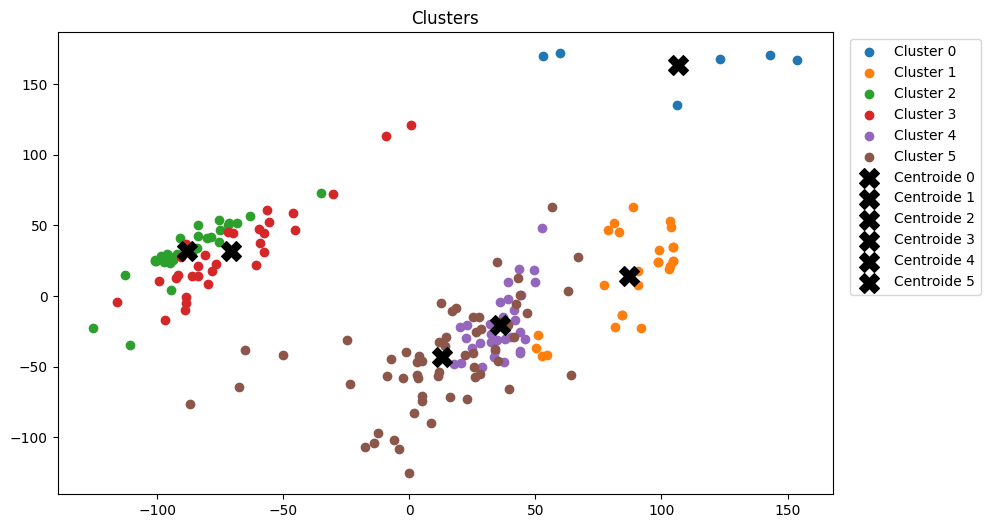

In [61]:
# Definir k
k = 6
new_centroides, clusters = kmeans(df_pca.to_numpy(), k, umbral)
clusters = np.array(clusters, dtype=int)
unique_clusters = np.unique(clusters)
plt.figure(figsize=(10, 6))

for cluster in unique_clusters:
    plt.scatter(df_pca["PC1"][clusters == cluster], df_pca["PC2"][clusters == cluster], label=f'Cluster {cluster}')

for i, centroid in enumerate(new_centroides):
    plt.scatter(centroid[0], centroid[1], marker="X", color="black", s=200, label=f'Centroide {i}')

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.title('Clusters')
plt.show()


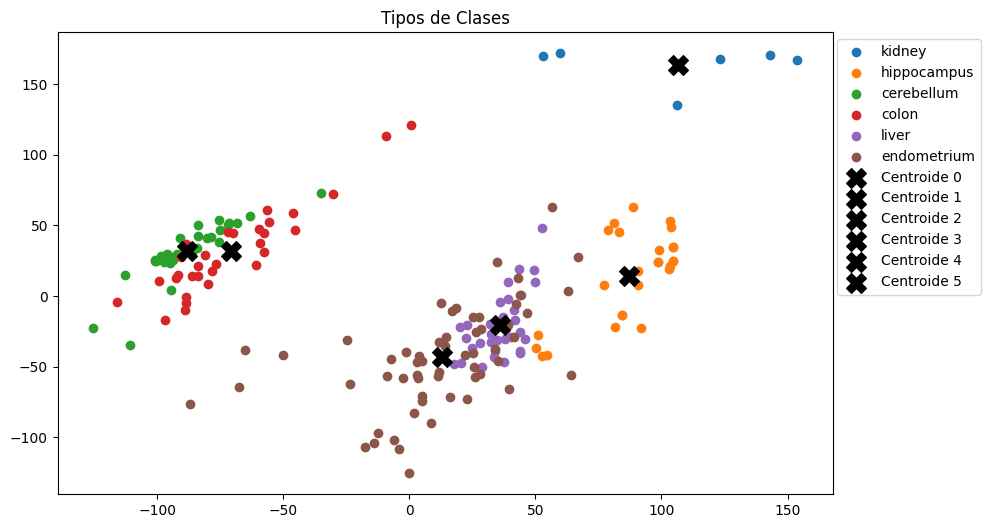

In [62]:
clases = names['x'].unique()
plt.figure(figsize=(10, 6))
for cluster in unique_clusters:
    plt.scatter(df_pca["PC1"][clusters == cluster], df_pca["PC2"][clusters == cluster], label=clases[cluster])
for i, centroid in enumerate(new_centroides):
    plt.scatter(centroid[0], centroid[1], marker="X", color="black", s=200, label=f'Centroide {i}')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

plt.title('Tipos de Clases')
plt.show()

In [63]:
true_labels_path = 'clase.txt'
true_labels = pd.read_csv(true_labels_path, header=None, skiprows=1, usecols=[1]).values.flatten()

computed_labels = clusters

homogeneity = metrics.homogeneity_score(true_labels, computed_labels)
completeness = metrics.completeness_score(true_labels, computed_labels)
v_measure = metrics.v_measure_score(true_labels, computed_labels)
silhouette = metrics.silhouette_score(df_pca, computed_labels, metric='euclidean')
davies_bouldin = metrics.davies_bouldin_score(df_pca, computed_labels)
adjusted_rand = metrics.adjusted_rand_score(true_labels, computed_labels)

print(f"Homogeneity: {homogeneity:.2f}")
print(f"Completeness: {completeness:.2f}")
print(f"V-measure: {v_measure:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")
print(f"Adjusted Rand Index: {adjusted_rand:.2f}")

Homogeneity: 0.78
Completeness: 0.87
V-measure: 0.82
Silhouette Score: 0.25
Davies-Bouldin Index: 1.59
Adjusted Rand Index: 0.73


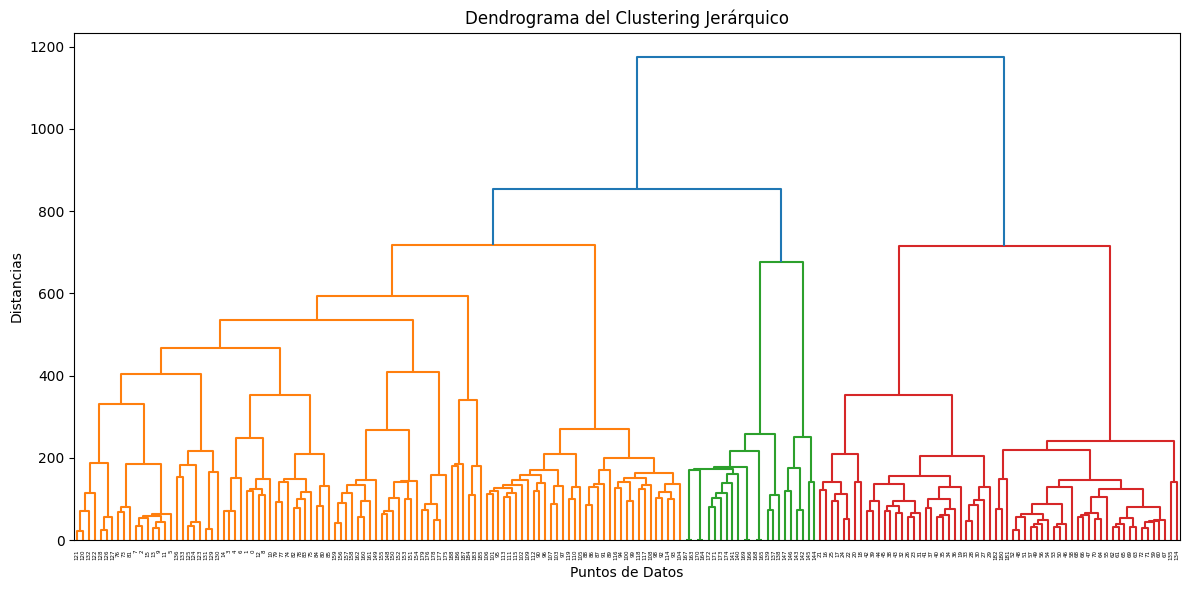

In [64]:
X_reduced = df_pca.to_numpy()
model = AgglomerativeClustering(n_clusters=k, metric='euclidean', linkage='ward')
model.fit(X_reduced)
Z = linkage(X_reduced, 'ward')
plt.figure(figsize=(12, 6))
dendrogram(Z,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Puntos de Datos')
plt.xticks(fontsize=4)
plt.ylabel('Distancias')
plt.tight_layout()
plt.show()